In [25]:
# 📦 All Preprocessing Helper Functions in One Cell

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.sparse import hstack
import re
import string
import nltk

# Make sure you have these
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# 1. Load data
def load_data(filepath):
    df = pd.read_csv(filepath)
    print(f"✅ Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    return df

# 2. Remove duplicates
def remove_duplicates(df):
    before = df.shape[0]
    df = df.drop_duplicates()
    after = df.shape[0]
    print(f"🔎 Found {before - after} duplicate rows. ✅ After removing: {after} rows remain")
    return df

# 3. Handle missing values
def handle_missing(df):
    print("\n🔎 Missing values before cleaning:")
    print(df.isnull().sum())

    df = df.copy()
    df["Title"] = df["Title"].fillna("Unknown")
    df["Language"] = df["Language"].fillna("Unknown")
    df["Release Date"] = df["Release Date"].fillna("Unknown")
    df["Reading Ease"] = df["Reading Ease"].fillna(df["Reading Ease"].mean())

    print("\n✅ Missing values after cleaning:")
    print(df.isnull().sum())
    return df

# 4. Feature engineering
def feature_engineering(df):
    df = df.copy()
    df["Release Year"] = df["Release Date"].str.extract(r"(\d{4})")
    df["Release Year"] = pd.to_numeric(df["Release Year"], errors="coerce")
    return df

# 5. Clean text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

# 6. Clean categories
def clean_categories(df):
    df = df.copy()
    df["Categories"] = df["Categories"].astype(str).str.replace(r"[\[\]']", "", regex=True)
    return df

# 7. Handle rare classes
def handle_rare_classes(df, min_samples=3):
    counts = df["Categories"].value_counts()
    rare_classes = counts[counts < min_samples].index
    
    df["Categories"] = df["Categories"].apply(
        lambda x: "Other" if x in rare_classes else x
    )
    
    print(f"📉 Merged {len(rare_classes)} rare categories into 'Other'")
    print("✅ Categories after handling rare classes:")
    print(df["Categories"].value_counts().head(10))
    return df

# 8. Vectorization + Dimensionality reduction
def advanced_vectorize_features(df, svd_dim=100):
    df["Title_clean"] = df["Title"].apply(clean_text)
    df["Subjects_clean"] = df["Subjects"].apply(clean_text)
    df["Categories_clean"] = df["Categories"].apply(clean_text)

    tfidf_title = TfidfVectorizer(max_features=500)
    tfidf_subjects = TfidfVectorizer(max_features=500)
    tfidf_categories = TfidfVectorizer(max_features=500)

    X_title = tfidf_title.fit_transform(df["Title_clean"])
    X_subjects = tfidf_subjects.fit_transform(df["Subjects_clean"])
    X_categories = tfidf_categories.fit_transform(df["Categories_clean"])

    X_combined = hstack([X_title, X_subjects, X_categories])

    svd = TruncatedSVD(n_components=svd_dim, random_state=42)
    X_reduced = svd.fit_transform(X_combined)

    print(f"🔗 Combined + reduced feature matrix shape: {X_reduced.shape}")
    return X_reduced

# 9. Encode labels
def prepare_labels(df):
    le = LabelEncoder()
    y = le.fit_transform(df["Categories"])
    print(f"✅ Encoded {len(le.classes_)} unique categories")
    return y, le

# 10. Train-test split
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# 11. Full preprocessing pipeline
def full_preprocessing_pipeline(filepath):
    df = load_data(filepath)
    df = remove_duplicates(df)
    df = handle_missing(df)
    df = feature_engineering(df)
    df = clean_categories(df)
    df = handle_rare_classes(df, min_samples=3)   # ✅ before vectorization
    X = advanced_vectorize_features(df, svd_dim=100)
    y, label_encoder = prepare_labels(df)
    X_train, X_test, y_train, y_test = split_data(X, y)
    return df, X, y, label_encoder, X_train, X_test, y_train, y_test


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
df, X, y, label_encoder, X_train, X_test, y_train, y_test = full_preprocessing_pipeline("gutenberg_books_1_500.csv")


✅ Loaded dataset with 500 rows and 7 columns
🔎 Found 0 duplicate rows. ✅ After removing: 500 rows remain

🔎 Missing values before cleaning:
ID               0
Title           18
Language        18
Release Date    18
Subjects         0
Categories       0
Reading Ease    28
dtype: int64

✅ Missing values after cleaning:
ID              0
Title           0
Language        0
Release Date    0
Subjects        0
Categories      0
Reading Ease    0
dtype: int64
📉 Merged 55 rare categories into 'Other'
✅ Categories after handling rare classes:
Categories
PS: Language and Literatures: American and Canadian literature                                                           148
PR: Language and Literatures: English literature                                                                         117
Other                                                                                                                     69
PZ: Language and Literatures: Juvenile belles lettres                   

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

def compare_models(X_train, X_test, y_train, y_test, label_encoder):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Linear SVM": LinearSVC(random_state=42),
        "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average="macro", zero_division=0
        )

        results.append({
            "Model": name,
            "Accuracy": round(acc, 3),
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1-Score": round(f1, 3)
        })

    results_df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False).reset_index(drop=True)
    return results_df


In [28]:
results_df = compare_models(X_train, X_test, y_train, y_test, label_encoder)
results_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Linear SVM,1.00,1.000,1.000,1.000
1,Random Forest,0.97,0.925,0.931,0.918
2,Logistic Regression,0.96,0.816,0.826,0.821
3,KNN (k=5),0.93,0.704,0.728,0.711


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

def evaluate_balanced_models(X_train, X_test, y_train, y_test, label_encoder):
    models = {
        "Logistic Regression (balanced)": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "Linear SVM (balanced)": LinearSVC(class_weight="balanced"),
        "Random Forest (balanced)": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

        results.append({
            "Model": name,
            "Accuracy": round(acc, 3),
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1-Score": round(f1, 3)
        })

    return pd.DataFrame(results)


In [31]:
from xgboost import XGBClassifier

def evaluate_xgboost(X_train, X_test, y_train, y_test):
    model = XGBClassifier(
        eval_metric="mlogloss",
        use_label_encoder=False,
        random_state=42,
        scale_pos_weight=1,  # we can tweak imbalance handling later
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

    return pd.DataFrame([{
        "Model": "XGBoost",
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3)
    }])


In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

def evaluate_text_nb(df, y, y_train, y_test, label_encoder):
    # Use only Subjects + Categories text
    df["text_features"] = df["Subjects"] + " " + df["Categories"]

    vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
    X_text = vectorizer.fit_transform(df["text_features"])

    # Split manually aligned with earlier train/test
    X_text_train = X_text[:len(y_train)]
    X_text_test = X_text[len(y_train):]

    model = MultinomialNB()
    model.fit(X_text_train, y_train)
    y_pred = model.predict(X_text_test)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

    return pd.DataFrame([{
        "Model": "Text-only MultinomialNB",
        "Accuracy": round(acc, 3),
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3)
    }])


In [33]:
# Run balanced models
balanced_results = evaluate_balanced_models(X_train, X_test, y_train, y_test, label_encoder)

# Run XGBoost
xgb_results = evaluate_xgboost(X_train, X_test, y_train, y_test)

# Run text-only Naive Bayes
nb_results = evaluate_text_nb(df, y, y_train, y_test, label_encoder)

# Merge all results
final_results = pd.concat([balanced_results, xgb_results, nb_results], ignore_index=True)
final_results


c:\Users\SHREYA\Demoprojects\homelib\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\SHREYA\Demoprojects\homelib\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:17:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SHREYA\Demoprojects\homelib\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\SHREYA\Demoprojects\homelib\Li

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression (balanced),0.99,0.995,0.99,0.991
1,Linear SVM (balanced),0.99,0.995,0.99,0.991
2,Random Forest (balanced),0.98,0.963,0.98,0.971
3,XGBoost,0.99,0.985,0.99,0.987
4,Text-only MultinomialNB,0.28,0.146,0.28,0.174


In [34]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def cross_validate_model(model, X, y, cv=5):
    """
    Run stratified k-fold cross-validation on given model.
    Returns mean accuracy and per-fold scores.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=skf, scoring="accuracy")
    
    print(f"✅ Cross-validation mean accuracy: {scores.mean():.3f}")
    print(f"📊 Fold-wise accuracy: {scores}")
    return scores


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, label_encoder):
    """
    Plot confusion matrix with labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    labels = label_encoder.classes_
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("📊 Confusion Matrix")
    plt.show()


c:\Users\SHREYA\Demoprojects\homelib\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


✅ Cross-validation mean accuracy: 0.992
📊 Fold-wise accuracy: [1.   0.99 0.99 0.99 0.99]


c:\Users\SHREYA\Demoprojects\homelib\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


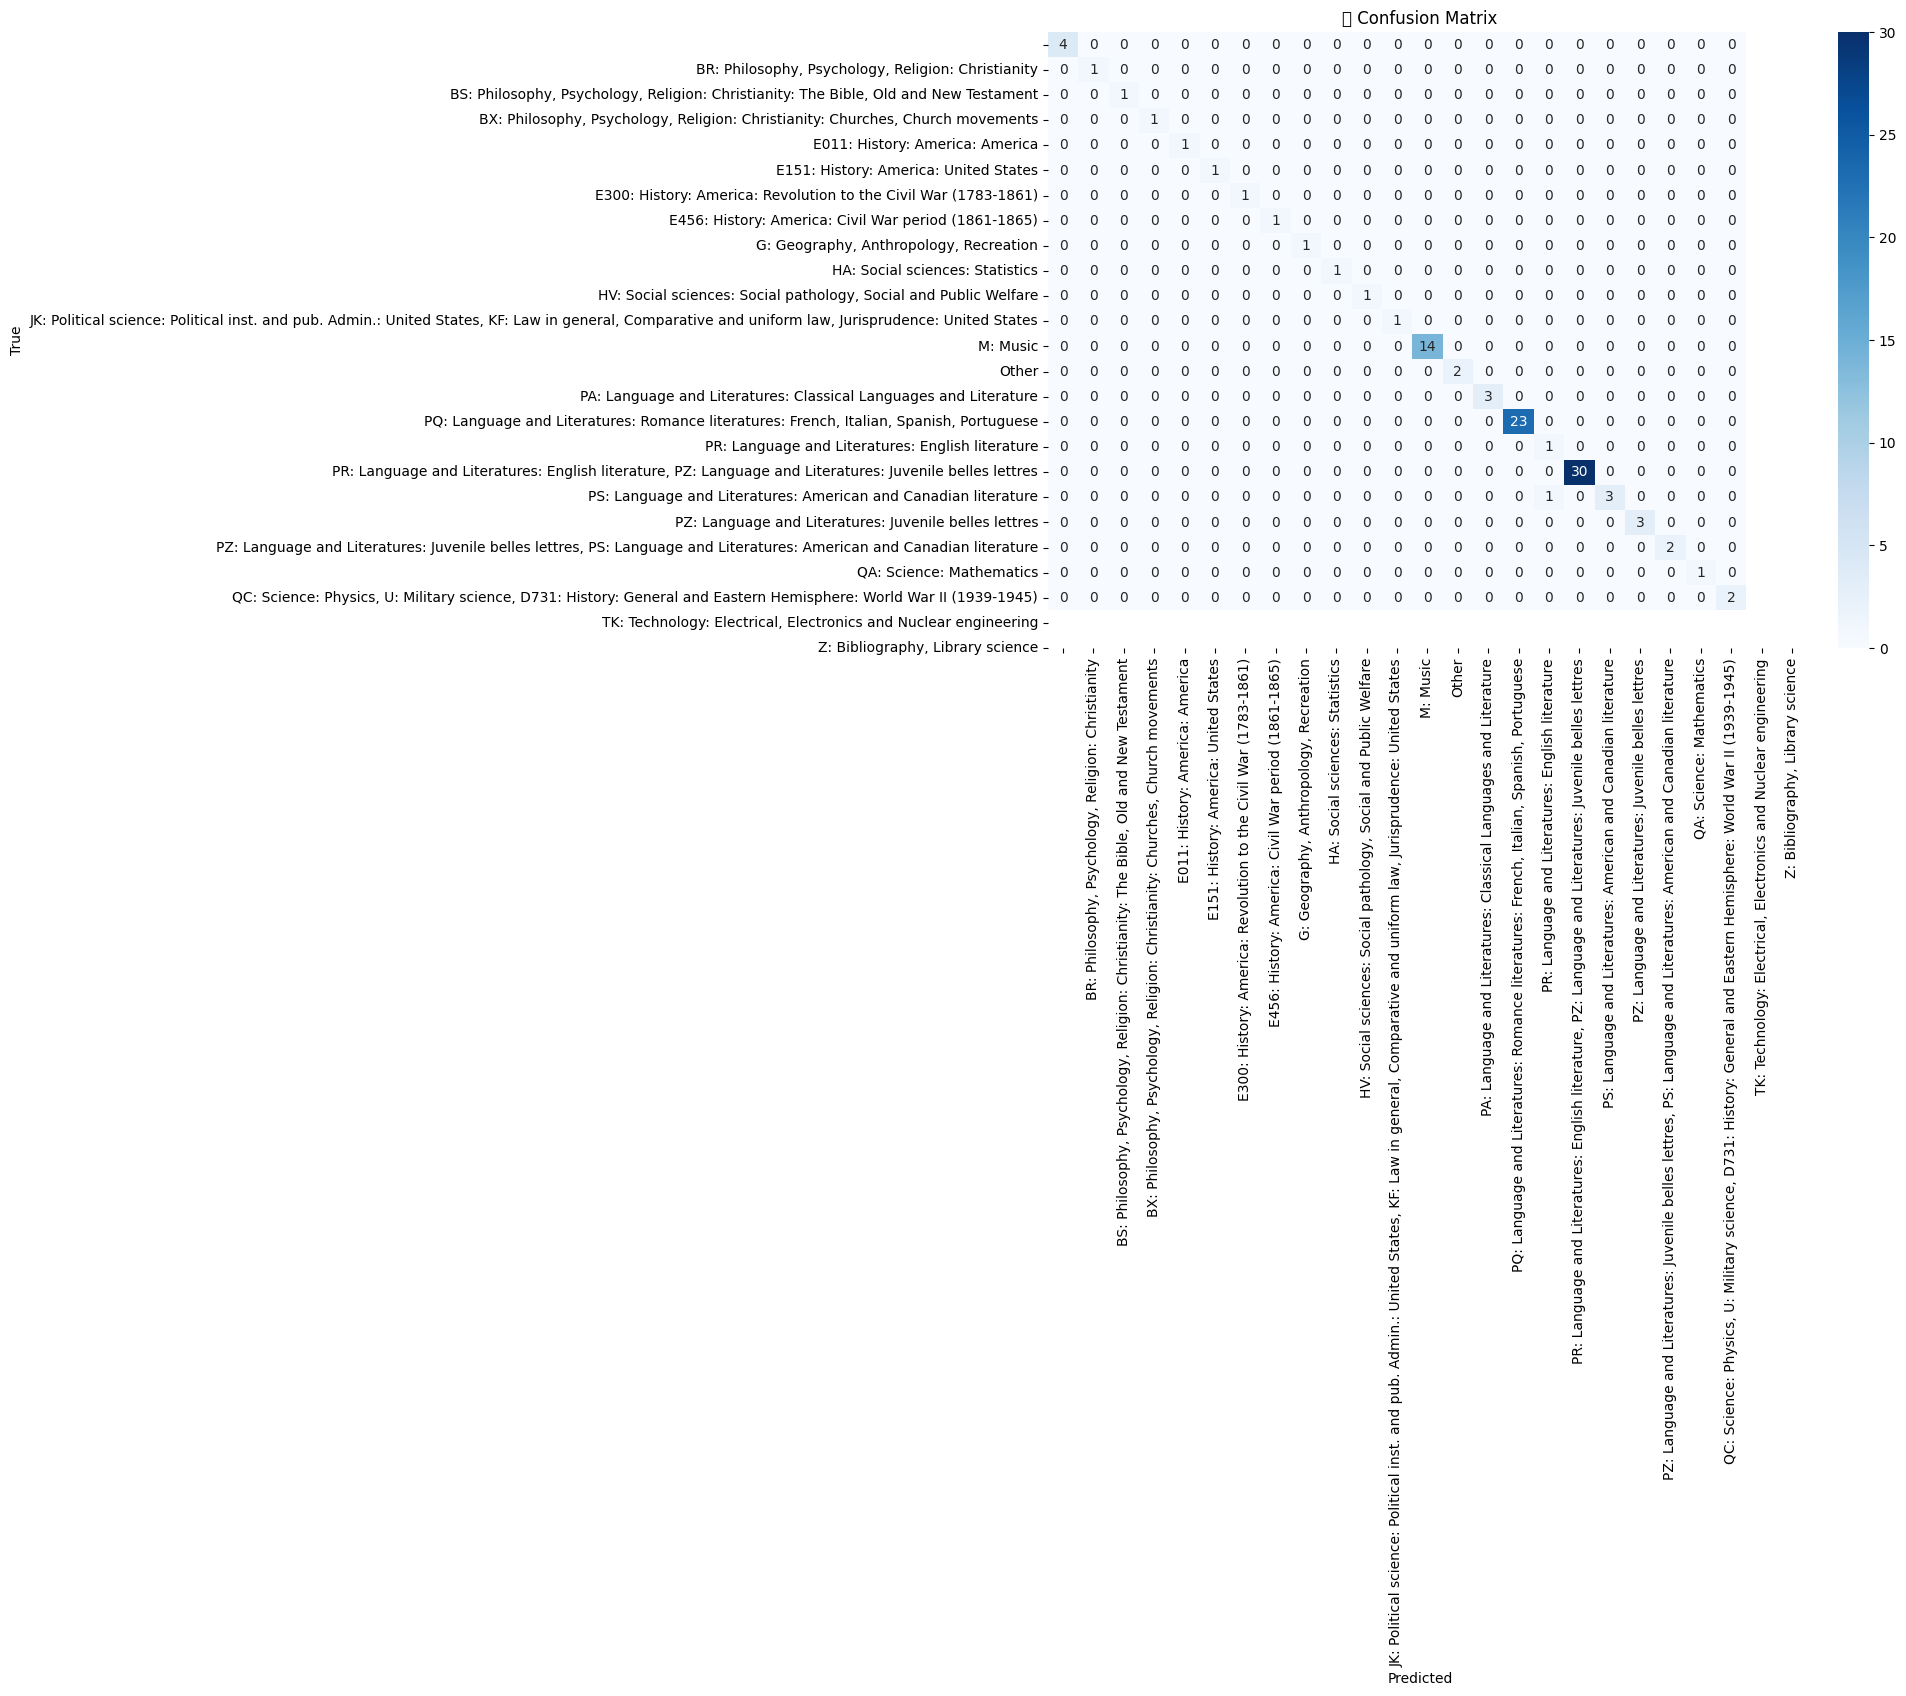

In [36]:
from sklearn.linear_model import LogisticRegression

# Train on full dataset
clf = LogisticRegression(max_iter=2000, class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# 1. Cross-validation
cross_validate_model(clf, X, y, cv=5)

# 2. Confusion matrix
plot_confusion_matrix(y_test, y_pred, label_encoder)


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

def compare_models(X_train, X_test, y_train, y_test, label_encoder):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Linear SVM": LinearSVC(random_state=42),
        "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
    }

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)

        # Predictions on train and test
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training accuracy
        train_acc = accuracy_score(y_train, y_train_pred)
        # Testing accuracy
        test_acc = accuracy_score(y_test, y_test_pred)

        # Precision/Recall/F1 on test set
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_test_pred, average="macro", zero_division=0
        )

        results.append({
            "Model": name,
            "Train Accuracy": round(train_acc, 3),
            "Test Accuracy": round(test_acc, 3),
            "Precision (Test)": round(precision, 3),
            "Recall (Test)": round(recall, 3),
            "F1-Score (Test)": round(f1, 3)
        })

    results_df = pd.DataFrame(results).sort_values(by="Test Accuracy", ascending=False).reset_index(drop=True)
    return results_df

# Run the comparison
results_df = compare_models(X_train, X_test, y_train, y_test, label_encoder)
print(results_df)


                 Model  Train Accuracy  Test Accuracy  Precision (Test)  \
0           Linear SVM           1.000           1.00             1.000   
1        Random Forest           1.000           0.97             0.925   
2  Logistic Regression           0.983           0.96             0.816   
3            KNN (k=5)           0.953           0.93             0.704   

   Recall (Test)  F1-Score (Test)  
0          1.000            1.000  
1          0.931            0.918  
2          0.826            0.821  
3          0.728            0.711  


In [39]:

final_results

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression (balanced),0.99,0.995,0.99,0.991
1,Linear SVM (balanced),0.99,0.995,0.99,0.991
2,Random Forest (balanced),0.98,0.963,0.98,0.971
3,XGBoost,0.99,0.985,0.99,0.987
4,Text-only MultinomialNB,0.28,0.146,0.28,0.174


In [40]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import LinearSVC

# 1. Fit label encoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 2. Build pipeline (scaling + Linear SVM)
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Feature scaling
    ('svm', LinearSVC(random_state=42))  # Unbalanced Linear SVM
])

# 3. Train pipeline
svm_pipeline.fit(X_train, y_train_encoded)

# 4. Save pipeline and encoder
joblib.dump(svm_pipeline, "svm_pipeline.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("✅ SVM pipeline and Label Encoder saved successfully!")


✅ SVM pipeline and Label Encoder saved successfully!
